# Benchmarking to inform the Model API design.

I had several question that are important to answer to not hamstring our
performance when we start to commit to a Model API (https://github.com/Confirm-Solutions/confirmasaurus/pull/92):

1. Does slicing and copying a large array of uniforms (or other pregenerated random variates) cause performance issues?
   - See the end of the doc.
   - No! It does not. This is irrelevant even though I had previously
     suspected this was a significant cause of performance problems. Both the
     microbenchmark and later full benchmark demonstrate this. This is true
     across CPU and GPU.
2. What batch size should we use?
     - when the problem is memory bandwidth constrained (simple binomial with n_arm_samples getting large), there's a narrow band of optimal performance.
       - see the figures below for n_arm_samples = 128 and n_arm_samples = 350. These are severely memory constrained cases because all we do with each uniform samples is do a less than comparison against p --> one operation per number.
     - when the model is compute constrained or very small/fast, we should use the largest batches that we can. This will be mostly constrained by running out of memory in something like the `unifs < p` call.
     - for Lei, the optimal was 1024 x as many grid points as possible
3. Are the concatenations in our current GPU code problematic?
   - No. We should use concatenation because it's simpler and not slower! This
     is great news and makes it easy to have a clean `batch(...)` code.
   - Compare `batched_flip` to `batched_flip_noconcat` below.
4. Does it help to include the summation of rejections inside the jitted
   function call? Or can we factor that out into the calling code? It's nice to factor this out because then the Model API can just return test statistics and not be responsible for computing the number of rejections or doing the tuning.
   - it is sometimes faster to include the summation inside the jitted
     function call and sometimes slower. I am a bit confused about the behavior here but I'm guessing it has to do with the details of JAX compilation and how it is or isn't reordering operation.
   - to generalize:
     - for very very fast simulators, it's faster to include the summation
       inside the JIT call. The difference is 10-40% performance.
     - for slower simulations, it doesn't matter whether we include the summation inside the JIT and sometimes including the summation inside the JIT slows down overall 
   - compare `sum_stat` (sum inside JIT) to `sum_then_stat` (sum separate from main Model JIT) below.
5. What order should we batch in? Simulations outside and points inside or vice versa? 
	- for memory constrained cases like this binomial setting where there are lots of pregenerated uniforms that are being summed, it's much faster for the outer batch to be over simulations and the inner batch to be over simulation points.
	- In compute constrained cases, the ordering doesn't seem matter so we should tend to have the inner batch be over simulation points

None of this matters very much when applied to Lei. Except the bug I unearthened where we were copying uniforms to and from the GPU accidentally!


In [1]:
from confirm.outlaw.nb_util import setup_nb

setup_nb()

import time
import timeit
from functools import partial

import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd

from confirm.lewislib import batch
import confirm.mini_imprint.lewis_drivers as ld
from confirm.lewislib import lewis

## Optimizing the batching code


In [2]:
def simulator(p, unifs):
    return jnp.sum(unifs[:, :] < p[None, :]) / unifs.size


@jax.jit
def stat_sum(lam, theta, null_truth, unifs):
    p = jax.scipy.special.expit(theta)
    test_stats = jnp.sum(unifs[None, :, :, :] < p[:, None, None, :], axis=(2, 3)) / (
        unifs.shape[1] * unifs.shape[2]
    )
    rej = test_stats < lam
    return jnp.sum(rej * null_truth[:, None, 0], axis=-1)


def stat(theta, null_truth, unifs):
    p = jax.scipy.special.expit(theta)
    simulatev = jax.vmap(simulator, in_axes=(None, 0))
    test_stats = simulatev(p, unifs)
    false_test_stats = jnp.where(null_truth[0], test_stats, 100.0)
    return false_test_stats


statv = jax.jit(jax.vmap(stat, in_axes=(0, 0, None)))


@jax.jit
def sumlam(stats, lam):
    return jnp.sum(stats < lam, axis=-1)


def stat_then_sum(lam, theta, null_truth, unifs):
    stats = statv(theta, null_truth, unifs)
    out = sumlam(stats, lam)
    return out

In [3]:
def simple(unifs_chunk, _1, _2):
    return stat_sum(
        lam,
        theta,
        null_truth,
        unifs_chunk,
    ).block_until_ready()


def simple_then_sum(unifs_chunk, _1, _2):
    return stat_then_sum(
        lam,
        theta,
        null_truth,
        unifs_chunk,
    ).block_until_ready()


def batched(unifs_chunk, sim_batch_size, grid_batch_size):
    sim_batcher = batch.batch(
        stat_sum, sim_batch_size, in_axes=(None, None, None, 0), out_axes=(1,)
    )
    batched_stat_sum = batch.batch(
        lambda *args: sim_batcher(*args).sum(axis=-1),
        grid_batch_size,
        in_axes=(None, 0, 0, None),
    )
    return batched_stat_sum(lam, theta, null_truth, unifs_chunk).block_until_ready()


def batched_flip(statter):
    def f(unifs_chunk, sim_batch_size, grid_batch_size):
        batched_stat_sum = batch.batch(
            batch.batch(
                statter, grid_batch_size, in_axes=(None, 0, 0, None), out_axes=(0,)
            ),
            sim_batch_size,
            in_axes=(None, None, None, 0),
            out_axes=(1,),
        )
        res = batched_stat_sum(lam, theta, null_truth, unifs_chunk)
        return res.sum(axis=1).block_until_ready()

    f.__name__ = batched_flip.__name__ + "_" + statter.__name__
    return f


def batched_flip_noconcat(statter):
    def f(unifs_chunk, sim_batch_size, grid_batch_size):
        batched_stat_sum = batch.batch_all(
            batch.batch_all(statter, grid_batch_size, in_axes=(None, 0, 0, None)),
            sim_batch_size,
            in_axes=(None, None, None, 0),
        )
        res, _ = batched_stat_sum(lam, theta, null_truth, unifs_chunk)
        n_j = len(res[0][0])

        def entry(i, j):
            e = res[i][0][j]
            if j == n_j - 1:
                e[: -res[i][1]]
            return e

        return (
            jnp.block([[entry(i, j) for j in range(n_j)] for i in range(len(res))])
            .sum(axis=0)
            .block_until_ready()
        )

    f.__name__ = batched_flip_noconcat.__name__ + "_" + statter.__name__
    return f

In [4]:
lam = 0.5

In [8]:
fncs = [
    simple,
    simple_then_sum,
    batched,
    batched_flip(stat_sum),
    batched_flip(stat_then_sum),
    batched_flip_noconcat(stat_sum),
    batched_flip_noconcat(stat_then_sum),
]
import timeit

N = 4096
K = 2**17
print(K)
unifs = jax.random.uniform(jax.random.PRNGKey(0), (K, 1, 4))
theta = np.random.rand(N, 4)
null_truth = np.ones((N, 3), dtype=bool)
sim_sizes = np.full(N, 2**13)

sim_batch_size = K // 2
res = simple(unifs, 0, 0)
for f in fncs:
    res_compare = f(unifs, sim_batch_size, 1024)
    np.testing.assert_allclose(res, res_compare)
    print(
        f.__name__,
        min(timeit.repeat(lambda: f(unifs, sim_batch_size, 1024), repeat=15, number=1)),
    )

131072
simple 0.026381689000118058
simple_then_sum 0.0367482529982226
batched 0.02775223100252333
batched_flip_stat_sum 0.0277505320009368
batched_flip_stat_then_sum 0.03819189199930406
batched_flip_noconcat_stat_sum 0.027487642000778578
batched_flip_noconcat_stat_then_sum 0.038190991999726975


In [17]:
fncs = [
    simple,
    simple_then_sum,
    batched,
    batched_flip(stat_sum),
    batched_flip(stat_then_sum),
    batched_flip_noconcat(stat_sum),
    batched_flip_noconcat(stat_then_sum),
]
import timeit

N = 2048
K = 2**17
print(K)
unifs = jax.random.uniform(jax.random.PRNGKey(0), (K, 5, 4))
theta = np.random.rand(N, 4)
null_truth = np.ones((N, 3), dtype=bool)
sim_sizes = np.full(N, 2**13)

sim_batch_size = K // 4
res = simple(unifs, 0, 0)
for f in fncs:
    res_compare = f(unifs, sim_batch_size, 1024)
    np.testing.assert_allclose(res, res_compare)
    print(
        f.__name__,
        min(timeit.repeat(lambda: f(unifs, sim_batch_size, 1024), repeat=15, number=1)),
    )

131072
simple 0.04618555799970636
simple_then_sum 0.058547537999402266
batched 0.027022163001674926
batched_flip_stat_sum 0.026991964998160256
batched_flip_stat_then_sum 0.039897321999887936
batched_flip_noconcat_stat_sum 0.02687227000205894
batched_flip_noconcat_stat_then_sum 0.03972313000122085


In [6]:
N = 1024
theta = np.random.rand(N, 4)
null_truth = np.ones((N, 3), dtype=bool)
sim_sizes = np.full(N, 2**13)

grid_batch_size = 256
sim_batch_size = 1024
unifs = jax.random.uniform(jax.random.PRNGKey(0), (16384, 150, 4))

fncs = [
    simple,
    simple_then_sum,
    batched,
    batched_flip(stat_sum),
    batched_flip(stat_then_sum),
    batched_flip_noconcat(stat_sum),
    batched_flip_noconcat(stat_then_sum),
]
import timeit

res = simple(unifs, 0, 0)
for f in fncs:
    res_compare = f(unifs, 1024, 256)
    np.testing.assert_allclose(res, res_compare)
    print(
        f.__name__, min(timeit.repeat(lambda: f(unifs, 1024, 256), repeat=40, number=1))
    )

simple 0.10703535699940403
simple_then_sum 0.10711405400070362
batched 0.08246627699918463
batched_flip_stat_sum 0.0344620739997481
batched_flip_stat_then_sum 0.03599271100029
batched_flip_noconcat_stat_sum 0.034453373998985626
batched_flip_noconcat_stat_then_sum 0.035420624997641426


## What batch size??


In [210]:
bench_data = []


def batching_benchmark(
    n_arm_samples, K=32768, S=[4096, 8192, 16384, 32768], G=[128, 256, 512, 1024]
):
    unifs = jax.random.uniform(jax.random.PRNGKey(0), (32768, n_arm_samples, 4))
    fncs = [
        simple,
        batched_flip_noconcat(stat_sum),
        batched_flip_noconcat(stat_then_sum),
    ]

    for sim_batch_size in S:
        for grid_batch_size in G:
            for f in fncs:
                _ = f(unifs, sim_batch_size, grid_batch_size)
                runtime = min(
                    timeit.repeat(
                        lambda: f(unifs, sim_batch_size, grid_batch_size),
                        repeat=10,
                        number=1,
                    )
                )
                d = dict(
                    n_arm_samples=n_arm_samples,
                    sim_batch_size=sim_batch_size,
                    grid_batch_size=grid_batch_size,
                    fnc=f.__name__,
                    time=runtime,
                )
                bench_data.append(d)

In [211]:
batching_benchmark(1, G=[512, 1024])

In [212]:
batching_benchmark(4, G=[512, 1024])

In [213]:
batching_benchmark(8, G=[512, 1024])

In [214]:
batching_benchmark(16, G=[512, 1024])

In [215]:
batching_benchmark(32, S=[1024, 2048, 4096, 8192], G=[512, 1024])

In [216]:
batching_benchmark(64, K=16384, S=[1024, 2048, 4096], G=[512, 1024])

In [219]:
batching_benchmark(
    128, K=4096, S=[512, 768, 1024, 1280, 1536, 1792, 2048], G=[64, 128, 256, 512, 1024]
)

In [221]:
batching_benchmark(
    350, K=8192, S=[128, 256, 384, 512, 542, 574, 606, 640, 768, 1024], G=[512, 1024]
)

In [251]:
df = pd.DataFrame(bench_data)

,n_arm_samples,sim_batch_size,grid_batch_size,fnc_x,time_x,fnc_y,time_y
0,1,32768,512,batched_flip_noconcat_stat_sum,0.002233,simple,0.001936
1,4,32768,1024,batched_flip_noconcat_stat_sum,0.006254,simple,0.005963
2,8,32768,512,batched_flip_noconcat_stat_sum,0.011820,simple,0.011511
3,16,8192,1024,batched_flip_noconcat_stat_sum,0.012192,simple,0.021474
4,32,4096,1024,batched_flip_noconcat_stat_sum,0.015990,simple,0.041304
5,64,2048,1024,batched_flip_noconcat_stat_sum,0.054986,simple,0.079549
6,128,1280,1024,batched_flip_noconcat_stat_sum,0.057744,simple,0.156626
7,350,512,1024,batched_flip_noconcat_stat_sum,0.161948,simple,0.500543


In [ ]:
idxmin = df.loc[df["fnc"] != "simple"].groupby("n_arm_samples")["time"].idxmin()
results = df.loc[idxmin].merge(
    df.loc[df["fnc"] == "simple"],
    on=("n_arm_samples", "sim_batch_size", "grid_batch_size"),
)
results

,n_arm_samples,sim_batch_size,grid_batch_size,fnc,time
310,128,256,1024,batched_flip_noconcat_stat_sum,0.175722
325,128,512,1024,batched_flip_noconcat_stat_sum,0.083729
403,128,768,1024,batched_flip_noconcat_stat_sum,0.063098
340,128,1024,1024,batched_flip_noconcat_stat_sum,0.058573
412,128,1280,1024,batched_flip_noconcat_stat_sum,0.057744
421,128,1536,1024,batched_flip_noconcat_stat_sum,0.058469
430,128,1892,1024,batched_flip_noconcat_stat_sum,0.095335
355,128,2048,1024,batched_flip_noconcat_stat_sum,0.112932
370,128,4096,1024,batched_flip_noconcat_stat_sum,0.158626


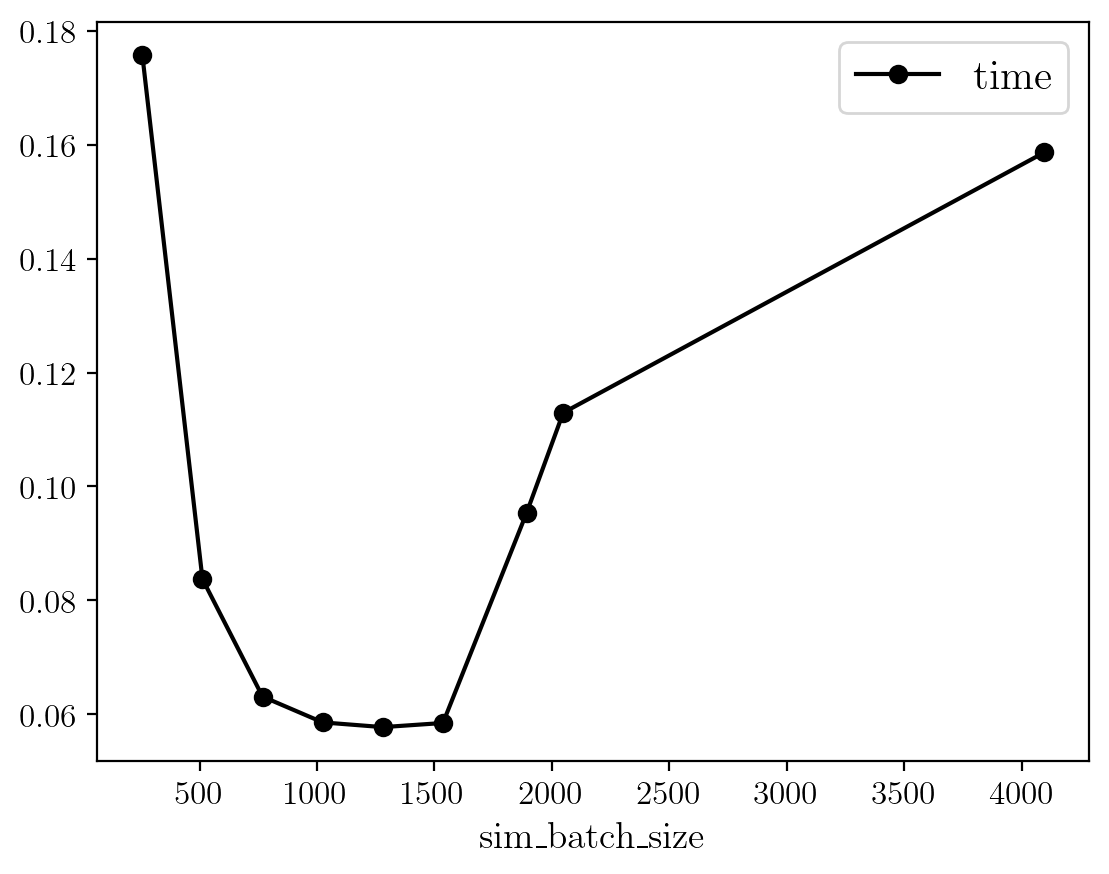

In [255]:
res128 = df.loc[
    (df["n_arm_samples"] == 128)
    & (df["fnc"] == "batched_flip_noconcat_stat_sum")
    & (df["grid_batch_size"] == 1024)
].sort_values("sim_batch_size")
res128.plot(x="sim_batch_size", y="time", style=["k-o"])
res128

,n_arm_samples,sim_batch_size,grid_batch_size,fnc,time
433,350,128,1024,batched_flip_noconcat_stat_sum,0.361869
376,350,256,1024,batched_flip_noconcat_stat_sum,0.185788
436,350,384,1024,batched_flip_noconcat_stat_sum,0.169217
382,350,512,1024,batched_flip_noconcat_stat_sum,0.161948
445,350,542,1024,batched_flip_noconcat_stat_sum,0.163861
448,350,574,1024,batched_flip_noconcat_stat_sum,0.193066
451,350,606,1024,batched_flip_noconcat_stat_sum,0.255044
439,350,640,1024,batched_flip_noconcat_stat_sum,0.312146
442,350,768,1024,batched_flip_noconcat_stat_sum,0.419208
388,350,1024,1024,batched_flip_noconcat_stat_sum,0.461495


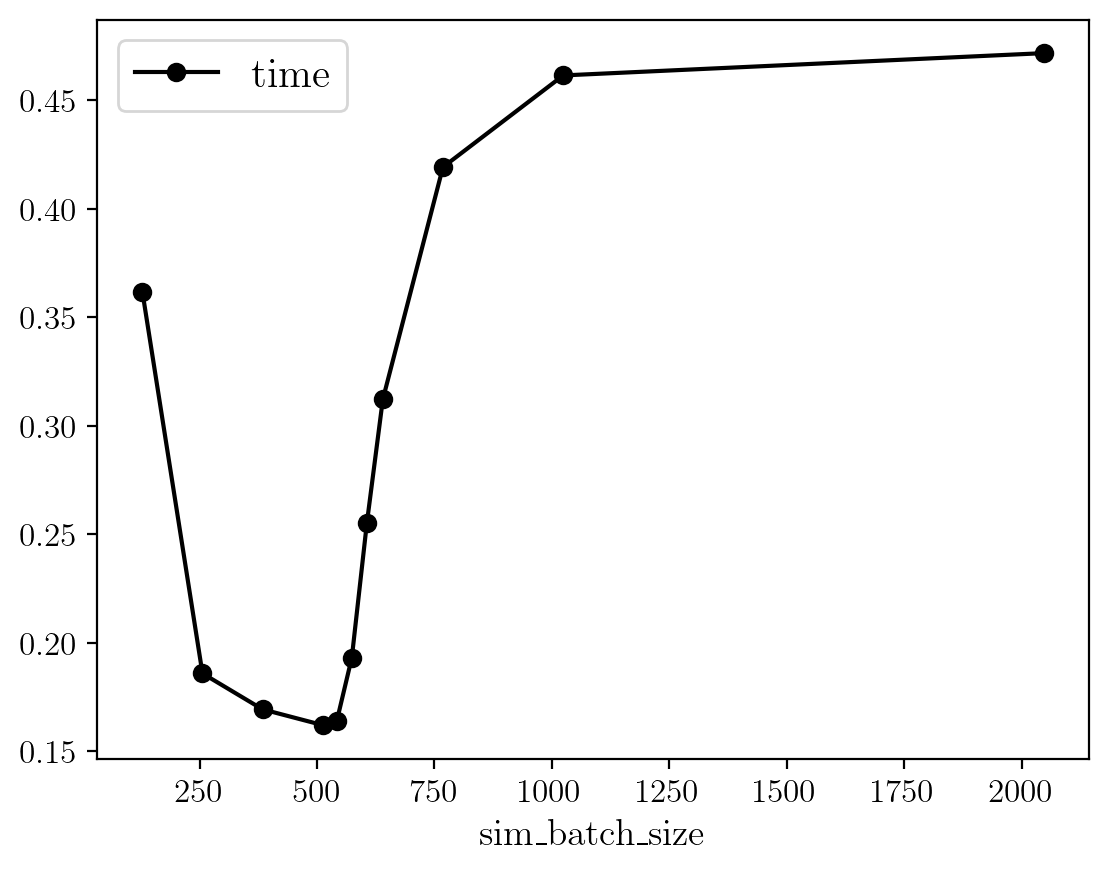

In [256]:
res350 = df.loc[
    (df["n_arm_samples"] == 350)
    & (df["fnc"] == "batched_flip_noconcat_stat_sum")
    & (df["grid_batch_size"] == 1024)
].sort_values("sim_batch_size")
res350.plot(x="sim_batch_size", y="time", style=["k-o"])
res350

## Applying this to Lei


In [3]:
params = {
    "n_arms": 4,
    "n_stage_1": 50,
    "n_stage_2": 100,
    "n_stage_1_interims": 2,
    "n_stage_1_add_per_interim": 100,
    "n_stage_2_add_per_interim": 100,
    "stage_1_futility_threshold": 0.15,
    "stage_1_efficacy_threshold": 0.7,
    "stage_2_futility_threshold": 0.2,
    "stage_2_efficacy_threshold": 0.95,
    "inter_stage_futility_threshold": 0.6,
    "posterior_difference_threshold": 0,
    "rejection_threshold": 0.05,
    "key": jax.random.PRNGKey(0),
    "n_table_pts": 20,
    "n_pr_sims": 100,
    "n_sig2_sims": 20,
    "batch_size": int(2**12),
    "cache_tables": f"./lei_cache.pkl",
}
lei_obj = lewis.Lewis45(**params)

In [8]:
N = 1024
theta = np.random.rand(N, 4) - 0.5
null_truth = np.ones((N, 3), dtype=bool)
# null_truth = np.random.rand(N, 3) < 0.5
sim_sizes = np.full(N, 2**13)
lam = 0.5

grid_batch_size = 256
sim_batch_size = 1024
unifs = jax.random.uniform(jax.random.PRNGKey(0), (16384, 350, 4))
unifs_order = jnp.arange(350)

In [9]:
# made unifs_order a global variable so that I don't need to change the code
# from above. this is lazy but fine for throwaway code.
def simulator(p, unifs):
    return lei_obj.simulate(p, unifs, unifs_order)[:2]


@jax.jit
@partial(jax.vmap, in_axes=(None, 0, 0, None))
def stat_sum(lam, theta, null_truth, unifs):
    p = jax.scipy.special.expit(theta)
    test_stats, best_arms = jax.vmap(simulator, in_axes=(None, 0))(p, unifs)
    rej = test_stats < lam
    return jnp.sum(rej * null_truth[best_arms - 1])


@jax.jit
@partial(jax.vmap, in_axes=(0, 0, None))
def stat(theta, null_truth, unifs):
    p = jax.scipy.special.expit(theta)
    test_stats, best_arms = jax.vmap(simulator, in_axes=(None, 0))(p, unifs)
    false_test_stats = jnp.where(null_truth[best_arms - 1], test_stats, jnp.inf)
    return false_test_stats


@jax.jit
def sumlam(stats, lam):
    return jnp.sum(stats < lam, axis=-1)


def stat_then_sum(lam, theta, null_truth, unifs):
    stats = stat(theta, null_truth, unifs)
    out = sumlam(stats, lam)
    return out

In [31]:
def simple(unifs_chunk, _1, _2):
    return stat_sum(
        lam,
        theta,
        null_truth,
        unifs_chunk,
    ).block_until_ready()

In [15]:
%%timeit
simple(unifs[:2048], None, None)

1.03 s ± 194 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
bench_data = []


def batching_benchmark(
    n_arm_samples, K=32768, S=[128, 256, 512, 1024], G=[256, 512, 1024]
):
    unifs = jax.random.uniform(jax.random.PRNGKey(0), (32768, n_arm_samples, 4))
    fncs = [
        batched_flip(stat_then_sum),
        batched_flip_noconcat(stat_sum),
    ]

    for sim_batch_size in S:
        stat_sum.clear_cache()
        stat.clear_cache()
        for grid_batch_size in G:
            for f in fncs:
                _ = f(unifs, sim_batch_size, grid_batch_size)
                runtime = min(
                    timeit.repeat(
                        lambda: f(unifs, sim_batch_size, grid_batch_size),
                        repeat=2,
                        number=1,
                    )
                )
                d = dict(
                    n_arm_samples=n_arm_samples,
                    sim_batch_size=sim_batch_size,
                    grid_batch_size=grid_batch_size,
                    fnc=f.__name__,
                    time=runtime,
                )
                print(d)
                bench_data.append(d)


batching_benchmark(350)

{'n_arm_samples': 350, 'sim_batch_size': 128, 'grid_batch_size': 256, 'fnc': 'batched_flip_stat_then_sum', 'time': 15.994368600000598}
{'n_arm_samples': 350, 'sim_batch_size': 128, 'grid_batch_size': 256, 'fnc': 'batched_flip_noconcat_stat_sum', 'time': 16.42251721499997}
{'n_arm_samples': 350, 'sim_batch_size': 128, 'grid_batch_size': 512, 'fnc': 'batched_flip_stat_then_sum', 'time': 15.448741715999859}
{'n_arm_samples': 350, 'sim_batch_size': 128, 'grid_batch_size': 512, 'fnc': 'batched_flip_noconcat_stat_sum', 'time': 15.903841723998994}
{'n_arm_samples': 350, 'sim_batch_size': 128, 'grid_batch_size': 1024, 'fnc': 'batched_flip_stat_then_sum', 'time': 15.052064120000068}
{'n_arm_samples': 350, 'sim_batch_size': 128, 'grid_batch_size': 1024, 'fnc': 'batched_flip_noconcat_stat_sum', 'time': 15.51607697899999}
{'n_arm_samples': 350, 'sim_batch_size': 256, 'grid_batch_size': 256, 'fnc': 'batched_flip_stat_then_sum', 'time': 15.403251601999727}
{'n_arm_samples': 350, 'sim_batch_size': 25

In [38]:
batching_benchmark(350, S=[2048, 4096], G=[1024])

{'n_arm_samples': 350, 'sim_batch_size': 2048, 'grid_batch_size': 1024, 'fnc': 'batched_flip_stat_then_sum', 'time': 16.41606926700115}
{'n_arm_samples': 350, 'sim_batch_size': 2048, 'grid_batch_size': 1024, 'fnc': 'batched_flip_noconcat_stat_sum', 'time': 16.496710010000243}
{'n_arm_samples': 350, 'sim_batch_size': 4096, 'grid_batch_size': 1024, 'fnc': 'batched_flip_stat_then_sum', 'time': 16.38653146899742}
{'n_arm_samples': 350, 'sim_batch_size': 4096, 'grid_batch_size': 1024, 'fnc': 'batched_flip_noconcat_stat_sum', 'time': 16.4624139309999}


In [40]:
df = pd.DataFrame(bench_data)
df

,n_arm_samples,sim_batch_size,grid_batch_size,fnc,time
0,350,128,256,batched_flip_stat_then_sum,15.994369
1,350,128,256,batched_flip_noconcat_stat_sum,16.422517
2,350,128,512,batched_flip_stat_then_sum,15.448742
3,350,128,512,batched_flip_noconcat_stat_sum,15.903842
4,350,128,1024,batched_flip_stat_then_sum,15.052064
5,350,128,1024,batched_flip_noconcat_stat_sum,15.516077
6,350,256,256,batched_flip_stat_then_sum,15.403252
7,350,256,256,batched_flip_noconcat_stat_sum,15.850203
8,350,256,512,batched_flip_stat_then_sum,15.011696
9,350,256,512,batched_flip_noconcat_stat_sum,15.450405


In [41]:
df.loc[df["time"].idxmin()]

n_arm_samples                                 350
sim_batch_size                               1024
grid_batch_size                              1024
fnc                batched_flip_noconcat_stat_sum
time                                    14.628499
Name: 23, dtype: object

## Is copying the uniforms array expensive?


In [ ]:
unifs = jax.random.uniform(jax.random.PRNGKey(0), (256000, 350, 4))
unifs10 = jax.random.uniform(jax.random.PRNGKey(0), (10000, 350, 4))
unifs2d = jax.random.uniform(jax.random.PRNGKey(0), (256000, 350, 1))

In [ ]:
for k in range(2):
    start = time.time()
    out1 = unifs.sum(axis=1).block_until_ready()
    if k >= 1:
        print("sum", time.time() - start)

    start = time.time()
    copy = unifs.copy().block_until_ready()
    if k >= 1:
        print("copy", time.time() - start)

    start = time.time()
    out2 = unifs[:-1].sum(axis=1).block_until_ready()
    if k >= 1:
        print("slice[:-1].sum", time.time() - start)

    start = time.time()
    out2 = unifs[0 : unifs.shape[0]].sum(axis=1).block_until_ready()
    if k >= 1:
        print("slice[0:n].sum", time.time() - start)

    start = time.time()
    outs = []
    for i in range(0, unifs.shape[0], 10000):
        begin_idx = i
        end_idx = min(i + 10000, unifs.shape[0])
        outs.append(unifs[begin_idx:end_idx].sum(axis=1))
    out2 = jnp.concatenate(outs).block_until_ready()
    if k >= 1:
        print("batched sum", time.time() - start)
    np.testing.assert_allclose(out1, out2)

    start = time.time()
    unifs10.sum(axis=1).block_until_ready()
    if k >= 1:
        print("sum10k no slice", time.time() - start)

    start = time.time()
    unifs[:10000].sum(axis=1).block_until_ready()
    if k >= 1:
        print("sum10k with slice", time.time() - start)

    start = time.time()
    unifs2d.sum(axis=1).block_until_ready()
    if k >= 1:
        print("sum2d no slice", time.time() - start)

    start = time.time()
    unifs[:, :, :1].sum(axis=1).block_until_ready()
    if k >= 1:
        print("sum2d with slice", time.time() - start)

sum 0.009685277938842773
copy 0.0075685977935791016
slice[:-1].sum 0.01752328872680664
slice[0:n].sum 0.009872198104858398
batched sum 0.023319244384765625
sum10k no slice 0.0009198188781738281
sum10k with slice 0.0017540454864501953
sum2d no slice 0.0010247230529785156
sum2d with slice 0.006093502044677734
